# LSME Quick Start

This notebook provides a quick introduction to LSME (Local Structural Matrix Embeddings).

## What you'll learn
- Basic usage with common graphs
- Understanding the output structure
- Visualizing signature matrices
- 2D projection of embeddings

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from lsme import LSME

## 1. Basic Usage

Load a graph and compute embeddings with default settings.

In [2]:
# Load Zachary's Karate Club graph
G = nx.karate_club_graph()
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")

Nodes: 34
Edges: 78


In [3]:
# Create LSME embedder
lsme = LSME(
    method='stochastic',  # default
    max_hops=2,           # neighborhood radius
    n_samples=100,        # permutation samples
    embedding_dim=32,     # output dimension
    verbose=True,
    random_state=42
)

# Compute embeddings
result = lsme.fit_transform(G)

Computing signature for node 0 (1/34)...
Computing signature for node 1 (2/34)...
Computing signature for node 2 (3/34)...
Computing signature for node 3 (4/34)...
Computing signature for node 4 (5/34)...
Computing signature for node 5 (6/34)...
Computing signature for node 6 (7/34)...
Computing signature for node 7 (8/34)...
Computing signature for node 8 (9/34)...
Computing signature for node 9 (10/34)...
Computing signature for node 10 (11/34)...
Computing signature for node 11 (12/34)...
Computing signature for node 12 (13/34)...
Computing signature for node 13 (14/34)...
Computing signature for node 14 (15/34)...
Computing signature for node 15 (16/34)...
Computing signature for node 16 (17/34)...
Computing signature for node 17 (18/34)...
Computing signature for node 18 (19/34)...
Computing signature for node 19 (20/34)...
Computing signature for node 20 (21/34)...
Computing signature for node 21 (22/34)...
Computing signature for node 22 (23/34)...
Computing signature for node 2

## 2. Understanding the Output

In [4]:
# What's in the result?
print("Result keys:", list(result.keys()))
print(f"\nMethod: {result['method']}")
print(f"Parameters: {result['params']}")

Result keys: ['embeddings', 'method', 'params', 'metadata', 'signature_matrices', 'layer_info', 'encoder']

Method: stochastic
Parameters: {'max_hops': 2, 'random_state': 42, 'n_samples': 100}


In [5]:
# Access embeddings
embeddings = result['embeddings']
print(f"Number of embeddings: {len(embeddings)}")
print(f"Embedding for node 0: shape={embeddings[0].shape}")
print(f"First 5 values: {embeddings[0][:5]}")

Number of embeddings: 34
Embedding for node 0: shape=(32,)
First 5 values: [-2.5968516   0.01869539 -3.8100324  -0.0419301  -1.8824987 ]


In [6]:
# Access signature matrices (stochastic method only)
sig_matrices = result['signature_matrices']
print(f"Signature matrix for node 0: shape={sig_matrices[0].shape}")
print(f"Signature matrix for node 33: shape={sig_matrices[33].shape}")

Signature matrix for node 0: shape=(26, 26)
Signature matrix for node 33: shape=(24, 24)


## 3. Visualizing the Graph

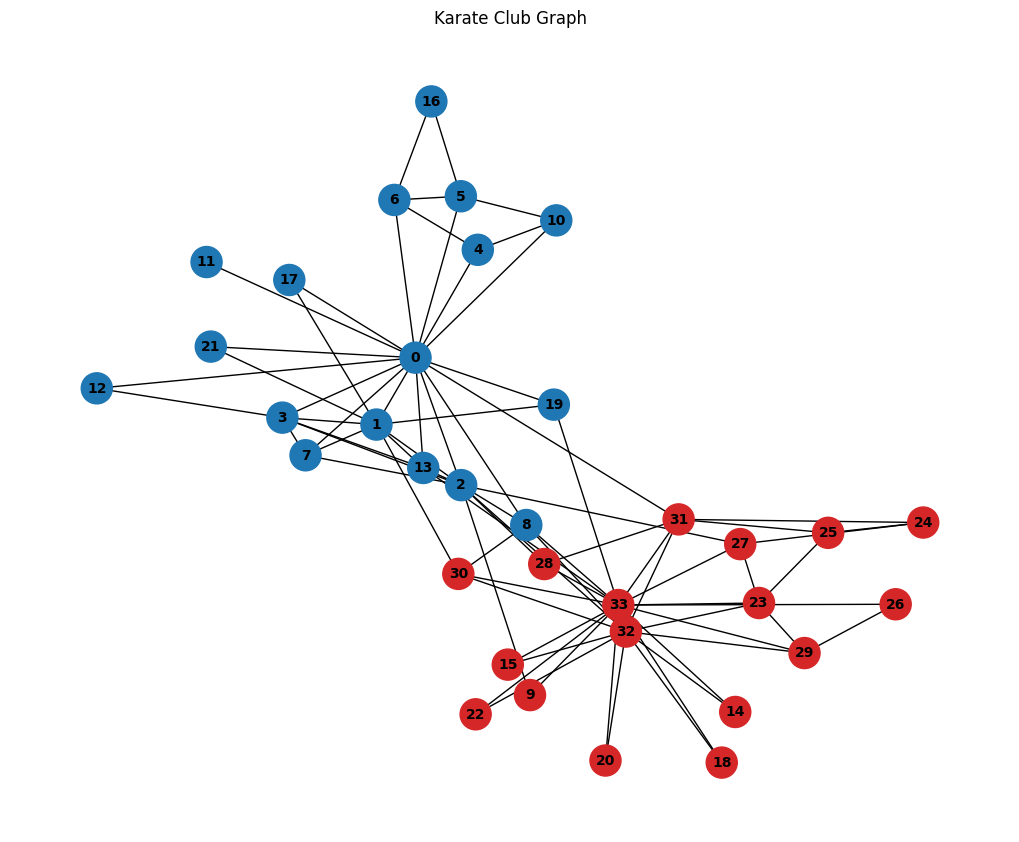

In [7]:
# Draw the Karate Club graph
plt.figure(figsize=(10, 8))

# Color by club membership
club = [G.nodes[n]['club'] for n in G.nodes()]
colors = ['#1f77b4' if c == 'Mr. Hi' else '#d62728' for c in club]

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_color=colors, with_labels=True, 
        node_size=500, font_size=10, font_weight='bold')
plt.title("Karate Club Graph")
plt.show()

## 4. Visualizing Signature Matrices

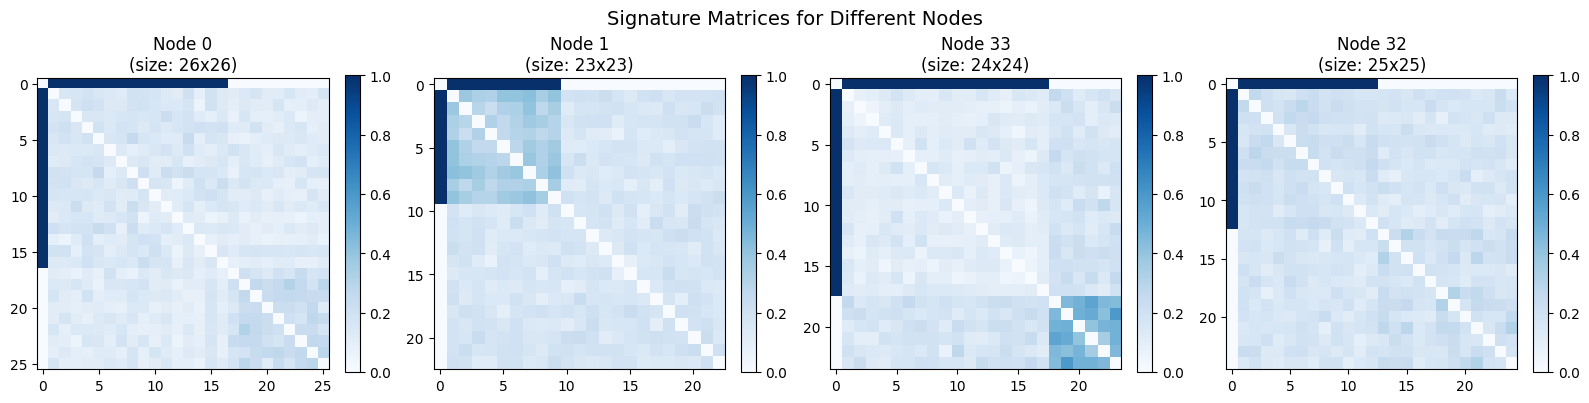

In [8]:
# Compare signature matrices for different nodes
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

nodes_to_show = [0, 1, 33, 32]  # Hub and peripheral nodes

for idx, node in enumerate(nodes_to_show):
    ax = axes[idx]
    im = ax.imshow(sig_matrices[node], cmap='Blues', vmin=0, vmax=1)
    ax.set_title(f'Node {node}\n(size: {sig_matrices[node].shape[0]}x{sig_matrices[node].shape[0]})')
    plt.colorbar(im, ax=ax, fraction=0.046)

plt.suptitle('Signature Matrices for Different Nodes', fontsize=14)
plt.tight_layout()
plt.show()

## 5. 2D Projection of Embeddings

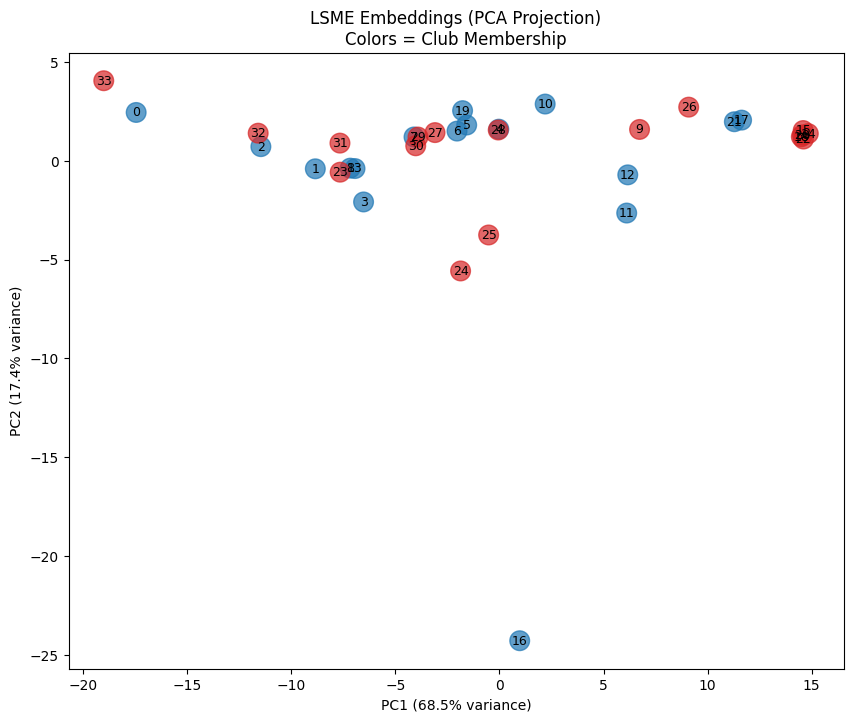

In [9]:
# Convert embeddings to matrix
nodes = sorted(embeddings.keys())
X = np.array([embeddings[n] for n in nodes])

# PCA projection
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Plot
plt.figure(figsize=(10, 8))

club_colors = ['#1f77b4' if G.nodes[n]['club'] == 'Mr. Hi' else '#d62728' for n in nodes]
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=club_colors, s=200, alpha=0.7)

for i, node in enumerate(nodes):
    plt.annotate(str(node), (X_2d[i, 0], X_2d[i, 1]), 
                 fontsize=9, ha='center', va='center')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('LSME Embeddings (PCA Projection)\nColors = Club Membership')
plt.show()

## 6. Using Different Methods

In [10]:
# List available methods
print("Available methods:", LSME.available_methods())

Available methods: ['deterministic', 'eigenvalue', 'random_walk', 'stochastic']


In [11]:
# Try deterministic method (faster, no encoder needed)
lsme_det = LSME(method='deterministic', max_hops=3, verbose=False)
result_det = lsme_det.fit_transform(G)

print(f"Deterministic embedding shape: {result_det['embeddings'][0].shape}")
print(f"Expected: 3 * (max_hops + 1) = 3 * 4 = 12")

Deterministic embedding shape: (12,)
Expected: 3 * (max_hops + 1) = 3 * 4 = 12


In [12]:
# Try eigenvalue method (fastest, smallest dimension)
lsme_eig = LSME(method='eigenvalue', max_hops=3, verbose=False)
result_eig = lsme_eig.fit_transform(G)

print(f"Eigenvalue embedding shape: {result_eig['embeddings'][0].shape}")
print(f"Expected: max_hops + 1 = 4")

Eigenvalue embedding shape: (4,)
Expected: max_hops + 1 = 4


## Summary

In this notebook, you learned:

1. **Basic usage**: Create an LSME object and call `fit_transform(G)`
2. **Output structure**: Embeddings, signature matrices, layer info, encoder
3. **Visualization**: How to visualize signature matrices and embeddings
4. **Methods**: Different embedding methods for different use cases

Next steps:
- Try `02_method_comparison.ipynb` for detailed method comparison
- Try `03_encoder_deep_dive.ipynb` for encoder configuration
- Try `05_analysis_example.ipynb` for ML applications